In [1]:
%load_ext autoreload
%autoreload 2
import os

from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger, LearningRateScheduler
from keras.optimizers import SGD, RMSprop

from data_generator import WrapperImageDataGenerator, custom_generator

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

Using TensorFlow backend.


In [2]:
EPOCHS = 100
IMAGES_ON_TRAIN = 44183
IMAGES_ON_VALIDATION = 10966

TRAIN_DATA_DIR = '/home/vs/Source/visionhack/data/trainset/data_to_fit_with_weight_train/'
VALID_DATA_DIR = '/home/vs/Source/visionhack/data/trainset/data_to_fit_with_weight_valid/'
IMAGE_SHAPE = (270, 480)
BATCH_SIZE = 64

train_generator = custom_generator('data/trainset/data_to_fit_with_weight_train/', BATCH_SIZE)
valid_generator = custom_generator('data/trainset/data_to_fit_with_weight_valid/', BATCH_SIZE)

In [3]:
MODEL_DATA_DIR = 'data/models'
LR = 0.045

#callbacks
checkpoint_path = 'checkpoints_weights.{epoch:02d}-{val_loss:.2f}.hdf5'
checkpoint_path = os.path.join(MODEL_DATA_DIR, checkpoint_path)
checkpointer = ModelCheckpoint(filepath=checkpoint_path, verbose=1, period=1)

stoper = EarlyStopping(min_delta=0.001, patience=7)

reducer = LearningRateScheduler(lambda e: LR * 0.94 ** (e // 2))

log_path = 'log.csv'
log_path = os.path.join(MODEL_DATA_DIR, log_path)
logger = CSVLogger(filename=log_path, append=True)

callbacks = [checkpointer, stoper, reducer]

In [ ]:
# create the base pre-trained model
base_model = InceptionV3(input_shape=(IMAGE_SHAPE[0], IMAGE_SHAPE[1], 3), weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
#x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(9, activation='sigmoid')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
# model.summary()
# model.load_weights('data/models/finetuned_checkpoints_weights.02-0.11.hdf5')

In [ ]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# model.summary()
    
optimizer = RMSprop(lr=LR, decay=0.9, epsilon=1)
    
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['MSE'])

model.fit_generator(train_generator, 
                    epochs=EPOCHS,
                    steps_per_epoch = int(IMAGES_ON_TRAIN / BATCH_SIZE),
                    verbose=1, 
                    validation_data=valid_generator,
                    callbacks=callbacks,  
                    validation_steps=int(0.1 * IMAGES_ON_VALIDATION / BATCH_SIZE), 
                    class_weight=None, 
                    initial_epoch=0)

Epoch 1/100
388/690 [===============>..............] - ETA: 453s - loss: 0.3151 - mean_squared_error: 0.0773

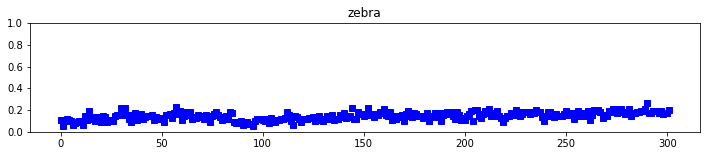

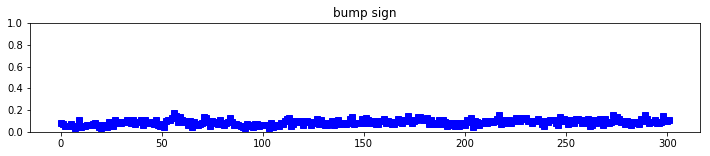

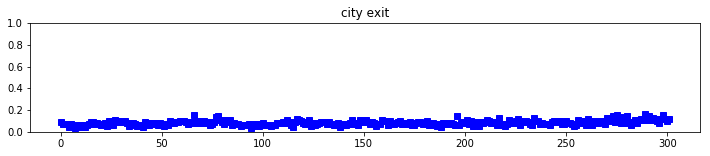

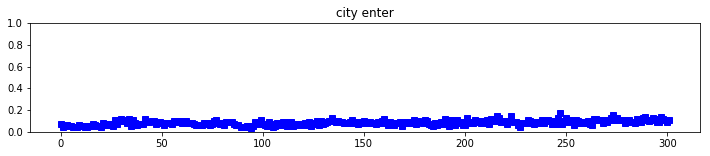

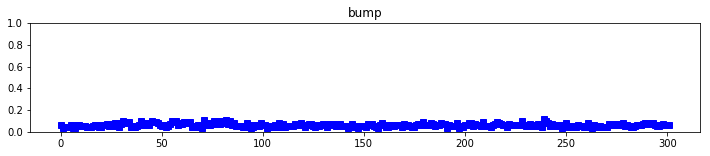

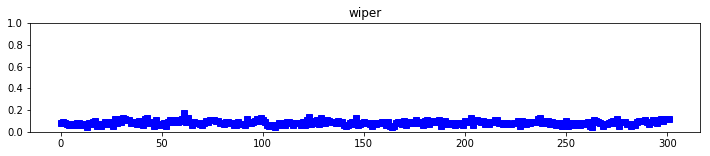

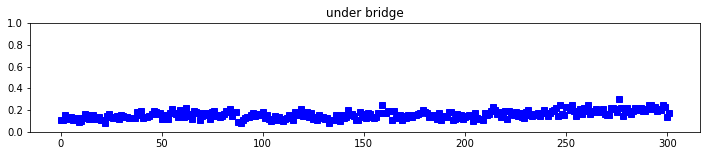

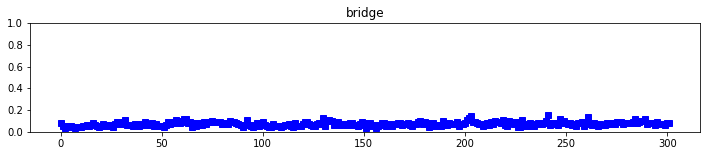

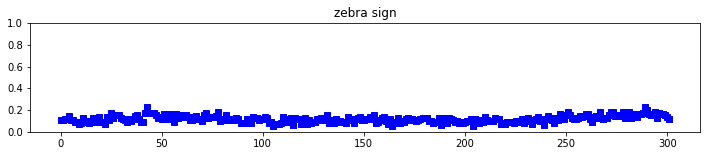

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import argparse
import os
import tqdm
import skvideo.io
import skimage.io
import skimage.transform
import numpy as np
from keras.applications.inception_v3 import preprocess_input

def predict_labels(video_path, extractor, img_shape, batch_size=64):
    reader = skvideo.io.FFmpegReader(video_path)
    num_frame = 0
    frames = []

    for frame in reader.nextFrame():
        frame = cv2.resize(frame, dsize=img_shape)
        frames.append(frame)
    result = extractor.predict(preprocess_input(np.array(frames[:302]).astype(float)), batch_size=batch_size)
    return result

labels = ["z", "c", "m", "t", "d", "b", "e", "x", "f"]
meaning_labels = ["zebra", "zebra sign", "bridge", "under bridge", "wiper", "bump", "city enter", "city exit", "bump sign"]

video_path = 'data/trainset/video/akn.031.029.left.avi'
Y = predict_labels(video_path, model, (299, 299))
c_images, c_class = Y.shape
for i in range(c_class):
    y = Y[:, i]
    plt.figure(figsize=(12, 2))
    plt.plot(range(c_images), y, 'bs')
    plt.title(meaning_labels[-i])
    plt.ylim((0, 1))
    plt.show()

In [17]:
FINETUNE_EPOCHS = 100
FINETUNE_LR = 0.0001

for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate

optimizer = RMSprop(lr=LR, decay=0.9, epsilon=1)
    
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['MSE'])

model.fit_generator(train_generator, 
                    epochs=EPOCHS,
                    steps_per_epoch = int(IMAGES_ON_TRAIN / BATCH_SIZE),
                    verbose=1, 
                    validation_data=valid_generator,
                    callbacks=callbacks,  
                    validation_steps=int(0.1 * IMAGES_ON_VALIDATION / BATCH_SIZE), 
                    class_weight=None, 
                    initial_epoch=0)

0 input_5
1 conv2d_377
2 batch_normalization_377
3 activation_377
4 conv2d_378
5 batch_normalization_378
6 activation_378
7 conv2d_379
8 batch_normalization_379
9 activation_379
10 max_pooling2d_17
11 conv2d_380
12 batch_normalization_380
13 activation_380
14 conv2d_381
15 batch_normalization_381
16 activation_381
17 max_pooling2d_18
18 conv2d_385
19 batch_normalization_385
20 activation_385
21 conv2d_383
22 conv2d_386
23 batch_normalization_383
24 batch_normalization_386
25 activation_383
26 activation_386
27 average_pooling2d_37
28 conv2d_382
29 conv2d_384
30 conv2d_387
31 conv2d_388
32 batch_normalization_382
33 batch_normalization_384
34 batch_normalization_387
35 batch_normalization_388
36 activation_382
37 activation_384
38 activation_387
39 activation_388
40 mixed0
41 conv2d_392
42 batch_normalization_392
43 activation_392
44 conv2d_390
45 conv2d_393
46 batch_normalization_390
47 batch_normalization_393
48 activation_390
49 activation_393
50 average_pooling2d_38
51 conv2d_389
52

KeyboardInterrupt: 